In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the data
with open('data/shell_comparison_RAL_with_prm3.json') as f:
# with open('data/shell_comparison_RAL_with_prm_variable_margin.json') as f:
    data = json.load(f)
    
    #shell_comparison_RAL_with_prm_variable_margin.json
    #shell_comparison_RAL_with_prm3.json
    
# with open('data/shell_comparison_RAL_with_prm3.json') as f:
#     data = json.load(f)

# Flatten the data and load it into a pandas DataFrame
df = pd.json_normalize(data)

# Rename the columns to remove the dots
df.columns = df.columns.str.split('.').str[-1]

# df = df[df['repId'] < 5]

df['time'] /= 1000
df = df[df['time'] < 200] # It seems we accidentally let some of the planners go past the 200s time limit, so we cut those off as invalid.

# Calculate n_visited/n_total
df['visit_ratio'] = df['n_visited'] / df['n_total']

# Get the maximum visit_ratio for each scene
max_visit_ratio = df.groupby('scene')['visit_ratio'].transform('max')

# Create a new column to indicate if the visit_ratio is below 0.95 times the maximum for that scene
df['low_visit_ratio'] = df['visit_ratio'] < 0.95 * max_visit_ratio

df['length_per_visited'] = df['total_path_length'] / df['n_visited']

In [3]:
def get_planner_name(planner, shell_type):
    """
    Given a planner and shell type, return a user-friendly planner name.
    
    Args:
        planner (str): The name of the planner.
        shell_type (str): The type of shell.
        
    Returns:
        str: A user-friendly planner name.
    """
    if planner == 'shell_based':
        if shell_type == 'minimum_enclosing_sphere':
            return 'Sphere Shell'
        elif shell_type == 'cgal_convex_hull':
            return 'Convex Hull Shell'
    elif planner.startswith('tsp_over_prm'):
        return 'TSPoPRM*'
    return None


def plot_scene_data(ax, scene_runs, color_map, low_color_map, handles, labels):
    """
    Plot the scene data on the given axis.
    
    Args:
        ax (matplotlib.axis): The axis to plot the data on.
        scene_runs (DataFrame): The data for the scene.
        color_map (dict): Mapping of planner names to colors.
        low_color_map (dict): Mapping of planner names to low ratio colors.
        handles (list): List to store handles for the legend.
        labels (list): List to store labels for the legend.
    """
    # Iterate through the groups of data defined by planner and shell type
    for ((planner, st), runs) in scene_runs.groupby(['name', 'shell_type'], dropna=False):
        
        # Get the user-friendly planner name
        name = get_planner_name(planner, st)
        
        if not name:
            continue
        
        # Select color based on the planner name
        color = color_map[name]
        
        # Split data based on visit_ratio
        low_ratio_data = runs[runs['low_visit_ratio']]
        high_ratio_data = runs[~runs['low_visit_ratio']]
        
        # Plot the high ratio data
        h1 = ax.scatter(high_ratio_data['time'], high_ratio_data['length_per_visited'], color=color)
        
        # Store handle and label for legend if not already stored
        if name not in labels:
            handles.append(h1)
            labels.append(name)
            
        # Plot the low ratio data if present
        low_color = low_color_map[name]
        h2 = ax.scatter(low_ratio_data['time'], low_ratio_data['length_per_visited'], color=low_color, marker='x', alpha=0.5)

        # Store handle and label for legend if not already stored
        if f'{name} (lv)' not in labels:
            handles.append(h2)
            labels.append(f'{name} (lv)')
            
        ax.grid()


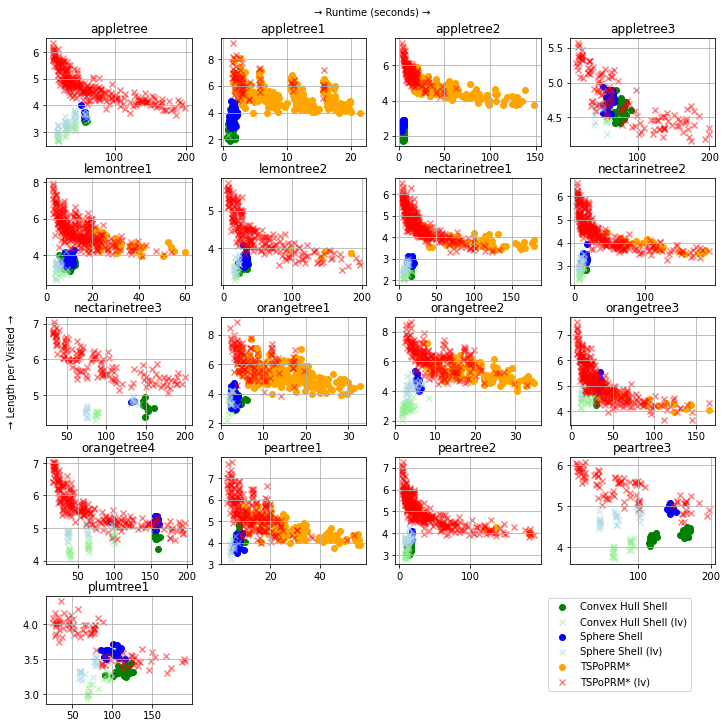

In [4]:
# Calculate the new metric
df['length_per_visited'] = df['total_path_length'] / df['n_visited']

# Create a color map for the planner names and shell types
unique_names = ['Sphere Shell', 'Convex Hull Shell', 'TSPoPRM*']
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_names)))
color_map = {
    'Sphere Shell': 'blue',
    'Convex Hull Shell': 'green',
    'TSPoPRM*': 'orange'
}

# Create a color map for low visit ratio data points
low_colors = plt.cm.autumn(np.linspace(0, 1, len(unique_names)))
low_color_map = {
    'Sphere Shell': 'lightblue',
    'Convex Hull Shell': 'lightgreen',
    'TSPoPRM*': 'red'
}

# Calculate number of scenes
num_scenes = len(df['scene'].unique())

# Calculate number of rows for subplots
nrows = (num_scenes + 3) // 4  # Add 3 to round up

# Create a grid of scatterplots
fig, axs = plt.subplots(nrows, 4, figsize=(10, 10))

# Keep track of handles and labels for the legend
handles, labels = [], []

grouped_scene = df.groupby('scene')

# Loop through each subplot and scene data
for i, (ax, (scene, scene_runs)) in enumerate(zip(axs.flatten(), grouped_scene)):
    
    # Plot data for this scene
    plot_scene_data(ax, scene_runs, color_map, low_color_map, handles, labels)
    
    # Set title and labels for this subplot
    ax.set_title(scene)

# Remove unused subplots
for j in range(i+1, nrows*4):
    fig.delaxes(axs.flatten()[j])
    
# Set common labels
fig.text(0.5, 1.0, '→ Runtime (seconds) →', ha='center', va='center')
fig.text(0.0, 0.5, '→ Length per Visited →', ha='center', va='center', rotation='vertical')

# Adjust the position of the legend
fig.legend(handles, labels, bbox_to_anchor=(0.95, 0.05), loc='lower right')

# Tight layout
plt.tight_layout()

fig.subplots_adjust(hspace=0.3,wspace=0.2)  # You can adjust the values as needed

plt.savefig('stats_length_per_visited_vs_time.pdf', dpi=300)

# Show plot
plt.show()

,name,prm_build_time,samples_per_goal,scene,approach_max_t,shell_type,low_visit_ratio,n_total,repId,n_visited,time,total_experiment_runtime,total_path_length,visit_ratio,length_per_visited
0,shell_based,NaN,NaN,appletree,0.10,cgal_convex_hull,True,165.0,4.500000,105.300000,17.962800,19422.100000,292.822183,0.638182,2.779100
1,shell_based,NaN,NaN,appletree,0.10,minimum_enclosing_sphere,True,165.0,4.500000,112.800000,18.900200,20380.100000,347.973504,0.683636,3.081603
2,shell_based,NaN,NaN,appletree,0.25,cgal_convex_hull,True,165.0,4.500000,115.700000,27.909100,29449.400000,356.398954,0.701212,3.078218
3,shell_based,NaN,NaN,appletree,0.25,minimum_enclosing_sphere,True,165.0,4.500000,126.100000,30.779900,32286.600000,422.970160,0.764242,3.352977
4,shell_based,NaN,NaN,appletree,0.50,cgal_convex_hull,True,165.0,4.500000,122.900000,38.472700,40074.100000,399.753222,0.744848,3.251955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,tsp_over_prm*,15.0,10.0,orangetree3,NaN,NaN,True,100.0,5.166667,81.166667,138.328500,139402.333333,335.767256,0.811667,4.135219
806,tsp_over_prm*,15.0,10.0,peartree1,NaN,NaN,False,50.0,4.222222,48.444444,53.111889,53548.666667,199.664398,0.968889,4.121275
807,tsp_over_prm*,15.0,10.0,peartree1,NaN,NaN,True,50.0,7.000000,47.000000,50.692000,51196.000000,194.788412,0.940000,4.144434
808,tsp_over_prm*,15.0,10.0,peartree2,NaN,NaN,False,100.0,4.000000,96.000000,182.821000,183434.000000,384.060366,0.960000,4.000629


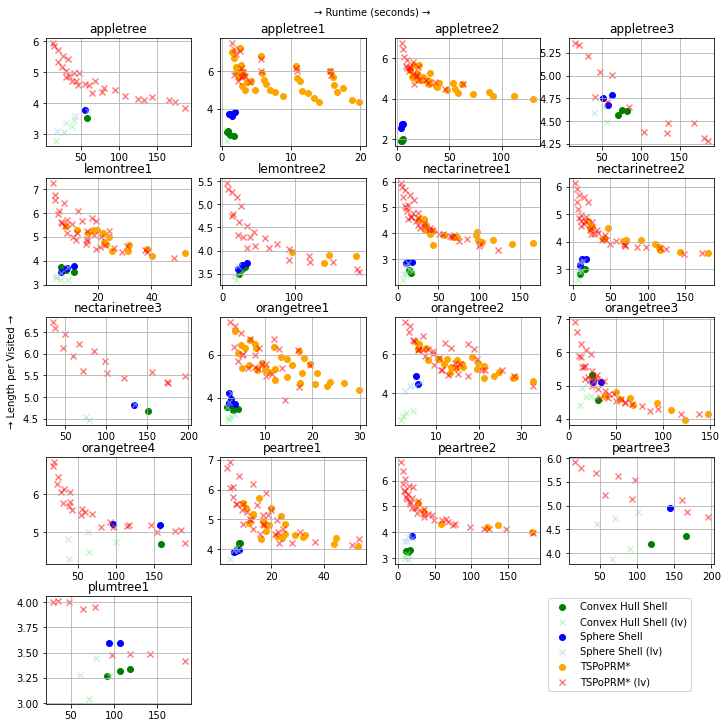

In [24]:
agg = df.groupby(['name','prm_build_time','samples_per_goal','scene','approach_max_t','shell_type','low_visit_ratio'], dropna=False).mean().reset_index()

# Create a color map for the planner names and shell types
unique_names = ['Sphere Shell', 'Convex Hull Shell', 'TSPoPRM*']
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_names)))
color_map = {
    'Sphere Shell': 'blue',
    'Convex Hull Shell': 'green',
    'TSPoPRM*': 'orange'
}

# Create a color map for low visit ratio data points
low_colors = plt.cm.autumn(np.linspace(0, 1, len(unique_names)))
low_color_map = {
    'Sphere Shell': 'lightblue',
    'Convex Hull Shell': 'lightgreen',
    'TSPoPRM*': 'red'
}

# Calculate number of scenes
num_scenes = len(df['scene'].unique())

# Calculate number of rows for subplots
nrows = (num_scenes + 3) // 4  # Add 3 to round up

# Create a grid of scatterplots
fig, axs = plt.subplots(nrows, 4, figsize=(10, 10))

# Keep track of handles and labels for the legend
handles, labels = [], []

grouped_scene = agg.groupby('scene')

# Loop through each subplot and scene data
for i, (ax, (scene, scene_runs)) in enumerate(zip(axs.flatten(), grouped_scene)):
    
    # Iterate through the groups of data defined by planner and shell type
    for ((planner, st), runs) in scene_runs.groupby(['name', 'shell_type'], dropna=False):
        
        # Get the user-friendly planner name
        name = get_planner_name(planner, st)
        
        if not name:
            continue
        
        # Select color based on the planner name
        color = color_map[name]
        
        # Split data based on visit_ratio
        low_ratio_data = runs[runs['low_visit_ratio']]
        high_ratio_data = runs[~runs['low_visit_ratio']]
        
        # Plot the high ratio data
        h1 = ax.scatter(high_ratio_data['time'], high_ratio_data['length_per_visited'], color=color)
        
        # Store handle and label for legend if not already stored
        if name not in labels:
            handles.append(h1)
            labels.append(name)
            
        # Plot the low ratio data if present
        low_color = low_color_map[name]
        h2 = ax.scatter(low_ratio_data['time'], low_ratio_data['length_per_visited'], color=low_color, marker='x', alpha=0.5)

        # Store handle and label for legend if not already stored
        if f'{name} (lv)' not in labels:
            handles.append(h2)
            labels.append(f'{name} (lv)')
            
        ax.grid()

    
    # Set title and labels for this subplot
    ax.set_title(scene)

# Remove unused subplots
for j in range(i+1, nrows*4):
    fig.delaxes(axs.flatten()[j])
    
# Set common labels
fig.text(0.5, 1.0, '→ Runtime (seconds) →', ha='center', va='center')
fig.text(0.0, 0.5, '→ Length per Visited →', ha='center', va='center', rotation='vertical')

# Adjust the position of the legend
fig.legend(handles, labels, bbox_to_anchor=(0.95, 0.05), loc='lower right')

# Tight layout
plt.tight_layout()

fig.subplots_adjust(hspace=0.3,wspace=0.2)  # You can adjust the values as needed

plt.savefig('stats_length_per_visited_vs_time_means.pdf', dpi=300,bbox_inches="tight")

# Show plot
plt.show()

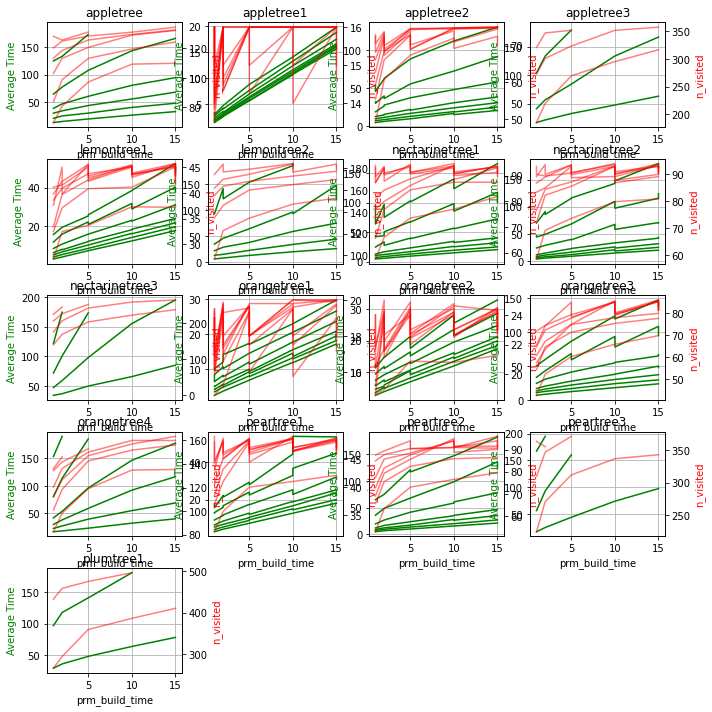

In [36]:
# Filter data for planner names containing 'tsp_over_prm*'
tsp_over_prm_data = agg[agg['name'].str.contains('tsp_over_prm')]

# Calculate number of scenes for tsp_over_prm data
num_scenes_tsp = len(tsp_over_prm_data['scene'].unique())

# Calculate number of rows for subplots for tsp_over_prm data
nrows_tsp = (num_scenes_tsp + 3) // 4  # Add 3 to round up

# Create a grid of scatterplots for tsp_over_prm data
fig_tsp, axs_tsp = plt.subplots(nrows_tsp, 4, figsize=(10, 10))

grouped_scene_tsp = tsp_over_prm_data.groupby('scene')

# Loop through each subplot and scene data for tsp_over_prm data
for i, (ax, (scene, scene_runs)) in enumerate(zip(axs_tsp.flatten(), grouped_scene_tsp)):
    
    # Create twin axes for n_visited
    ax2 = ax.twinx()
    
    # Group by samples_per_goal
    for samples_per_goal, group in scene_runs.groupby('samples_per_goal'):
        
        # Sort by prm_build_time for a continuous line plot
        group = group.sort_values('prm_build_time')
        
        # Plot average time against prm_build_time in green (on the first axis)
        ax.plot(group['prm_build_time'], group['time'], color='green', label=f'{samples_per_goal} samples_per_goal')
        
        # Plot n_visited in red (on the twin axis)
        ax2.plot(group['prm_build_time'], group['n_visited'], color='red', alpha=0.5, label=f'{samples_per_goal} samples_per_goal (n_visited)')
    
    # Set title and labels for this subplot
    ax.set_title(scene)
    ax.set_xlabel('prm_build_time')
    ax.set_ylabel('Average Time', color='green')
    ax2.set_ylabel('n_visited', color='red')
    ax.grid()

    # Add legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

# Remove unused subplots
for j in range(i+1, nrows_tsp*4):
    fig_tsp.delaxes(axs_tsp.flatten()[j])

# Tight layout
plt.tight_layout()

fig_tsp.subplots_adjust(hspace=0.3, wspace=0.2)  # You can adjust the values as needed

plt.savefig('tsp_over_prm_stats_with_n_visited.pdf', dpi=300, bbox_inches="tight")

# Show plot
plt.show()

